In [1]:
import os
import torch
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data_dir = 'data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
df = pd.read_csv(os.path.join(data_dir, 'final_data.csv'))
df['tau_ab_ratio'] = df['TAU_bl'] / df['ABETA_bl']
df['ptau_ab_ratio'] = df['PTAU_bl'] / df['ABETA_bl']
df['A+'] = df['ABETA_bl'].apply(lambda x: 1 if x < 880 else 0)
df['T+'] = df['ptau_ab_ratio'].apply(lambda x: 1 if x > 0.028 else 0)
df['N+'] = df['tau_ab_ratio'].apply(lambda x: 1 if x > 0.33 else 0)
df = df.drop(columns=['PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'tau_ab_ratio', 'ptau_ab_ratio'])

In [3]:
class SVM(torch.nn.Module):
    def __init__(self, features, targets):
        super(SVM, self).__init__()
        self.features = features
        self.targets = targets
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()

    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

# STL

## Predict A+

In [31]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['A+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [32]:
model = SVM(X_train, y_train).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.3395
Epoch [2/100], Loss: 1.2885
Epoch [3/100], Loss: 1.2432
Epoch [4/100], Loss: 1.2045
Epoch [5/100], Loss: 1.1677
Epoch [6/100], Loss: 1.1306
Epoch [7/100], Loss: 1.0941
Epoch [8/100], Loss: 1.0598
Epoch [9/100], Loss: 1.0314
Epoch [10/100], Loss: 1.0091
Epoch [11/100], Loss: 0.9899
Epoch [12/100], Loss: 0.9717
Epoch [13/100], Loss: 0.9539
Epoch [14/100], Loss: 0.9354
Epoch [15/100], Loss: 0.9151
Epoch [16/100], Loss: 0.8971
Epoch [17/100], Loss: 0.8838
Epoch [18/100], Loss: 0.8742
Epoch [19/100], Loss: 0.8671
Epoch [20/100], Loss: 0.8615
Epoch [21/100], Loss: 0.8567
Epoch [22/100], Loss: 0.8522
Epoch [23/100], Loss: 0.8478
Epoch [24/100], Loss: 0.8436
Epoch [25/100], Loss: 0.8395
Epoch [26/100], Loss: 0.8357
Epoch [27/100], Loss: 0.8323
Epoch [28/100], Loss: 0.8294
Epoch [29/100], Loss: 0.8270
Epoch [30/100], Loss: 0.8250
Epoch [31/100], Loss: 0.8234
Epoch [32/100], Loss: 0.8221
Epoch [33/100], Loss: 0.8208
Epoch [34/100], Loss: 0.8196
Epoch [35/100], Loss: 0

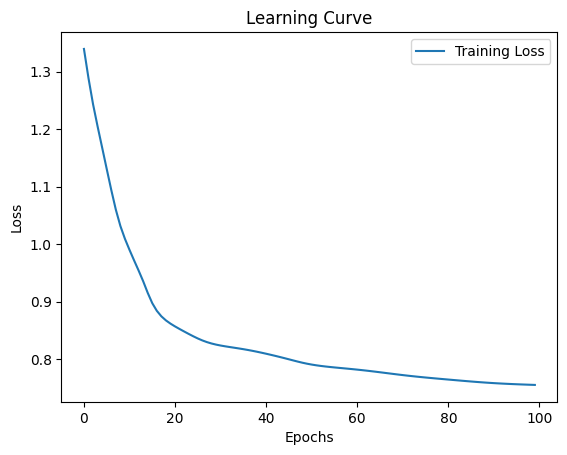

In [33]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [34]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print('ROC AUC:', roc_auc_score(y_train_np, y_pred_np))

Accuracy: 0.8594470046082949
Precision: 0.8767772511848341
Recall: 0.8409090909090909
F1 Score: 0.8584686774941995
ROC AUC: 0.8597068819031436


In [35]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))
    print('Test ROC AUC:', roc_auc_score(y_test_np, y_test_pred_np))

Test Accuracy: 0.8073394495412844
Test Precision: 0.8
Test Recall: 0.75
Test F1 Score: 0.7741935483870969
Test ROC AUC: 0.8012295081967213


# Predict T+

In [46]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['T+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [47]:
model = SVM(X_train, y_train, ).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 2.1638
Epoch [2/100], Loss: 2.1486
Epoch [3/100], Loss: 2.1316
Epoch [4/100], Loss: 2.1138
Epoch [5/100], Loss: 2.0952
Epoch [6/100], Loss: 2.0764
Epoch [7/100], Loss: 2.0569
Epoch [8/100], Loss: 2.0353
Epoch [9/100], Loss: 2.0098
Epoch [10/100], Loss: 1.9851
Epoch [11/100], Loss: 1.9640
Epoch [12/100], Loss: 1.9440
Epoch [13/100], Loss: 1.9230
Epoch [14/100], Loss: 1.9010
Epoch [15/100], Loss: 1.8788
Epoch [16/100], Loss: 1.8553
Epoch [17/100], Loss: 1.8289
Epoch [18/100], Loss: 1.7999
Epoch [19/100], Loss: 1.7680
Epoch [20/100], Loss: 1.7316
Epoch [21/100], Loss: 1.6932
Epoch [22/100], Loss: 1.6543
Epoch [23/100], Loss: 1.6148
Epoch [24/100], Loss: 1.5760
Epoch [25/100], Loss: 1.5345
Epoch [26/100], Loss: 1.4875
Epoch [27/100], Loss: 1.4363
Epoch [28/100], Loss: 1.3863
Epoch [29/100], Loss: 1.3342
Epoch [30/100], Loss: 1.2731
Epoch [31/100], Loss: 1.2096
Epoch [32/100], Loss: 1.1516
Epoch [33/100], Loss: 1.0952
Epoch [34/100], Loss: 1.0365
Epoch [35/100], Loss: 0

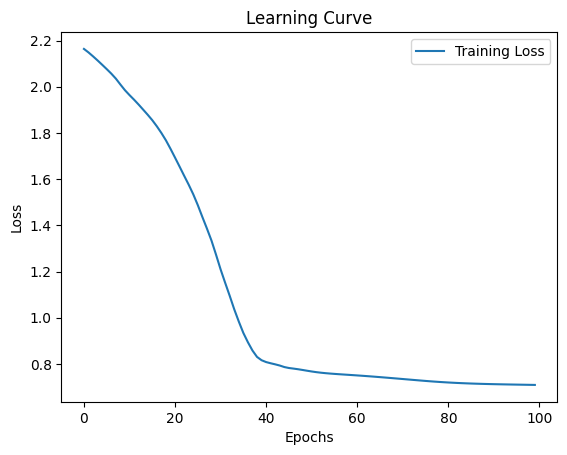

In [48]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [49]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print('ROC AUC:', roc_auc_score(y_train_np, y_pred_np))

Accuracy: 0.8778801843317973
Precision: 0.905
Recall: 0.8418604651162791
F1 Score: 0.8722891566265061
ROC AUC: 0.8775512371243495


In [50]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))
    print('Test ROC AUC:', roc_auc_score(y_test_np, y_test_pred_np))

Test Accuracy: 0.8899082568807339
Test Precision: 0.8863636363636364
Test Recall: 0.8478260869565217
Test F1 Score: 0.8666666666666666
Test ROC AUC: 0.8842305037957212


# Predict N+

In [61]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['N+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [62]:
model = SVM(X_train, y_train).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.7755
Epoch [2/100], Loss: 1.7477
Epoch [3/100], Loss: 1.7186
Epoch [4/100], Loss: 1.6858
Epoch [5/100], Loss: 1.6517
Epoch [6/100], Loss: 1.6202
Epoch [7/100], Loss: 1.5908
Epoch [8/100], Loss: 1.5602
Epoch [9/100], Loss: 1.5288
Epoch [10/100], Loss: 1.4965
Epoch [11/100], Loss: 1.4622
Epoch [12/100], Loss: 1.4289
Epoch [13/100], Loss: 1.3931
Epoch [14/100], Loss: 1.3505
Epoch [15/100], Loss: 1.3027
Epoch [16/100], Loss: 1.2543
Epoch [17/100], Loss: 1.2070
Epoch [18/100], Loss: 1.1631
Epoch [19/100], Loss: 1.1182
Epoch [20/100], Loss: 1.0650
Epoch [21/100], Loss: 1.0119
Epoch [22/100], Loss: 0.9641
Epoch [23/100], Loss: 0.9347
Epoch [24/100], Loss: 0.9158
Epoch [25/100], Loss: 0.8972
Epoch [26/100], Loss: 0.8811
Epoch [27/100], Loss: 0.8712
Epoch [28/100], Loss: 0.8634
Epoch [29/100], Loss: 0.8557
Epoch [30/100], Loss: 0.8479
Epoch [31/100], Loss: 0.8405
Epoch [32/100], Loss: 0.8339
Epoch [33/100], Loss: 0.8285
Epoch [34/100], Loss: 0.8239
Epoch [35/100], Loss: 0

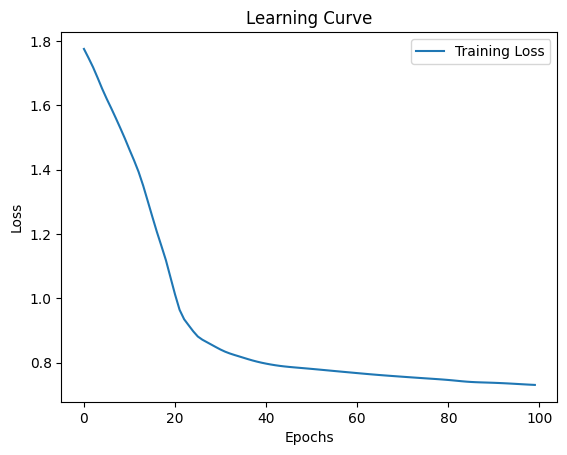

In [64]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [65]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))
    print('ROC AUC:', roc_auc_score(y_train_np, y_pred_np))

Accuracy: 0.8963133640552995
Precision: 0.8994974874371859
Recall: 0.8774509803921569
F1 Score: 0.8883374689826303
ROC AUC: 0.8952472293265132


In [66]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))
    print('Test ROC AUC:', roc_auc_score(y_test_np, y_test_pred_np))

Test Accuracy: 0.944954128440367
Test Precision: 0.9347826086956522
Test Recall: 0.9347826086956522
Test F1 Score: 0.9347826086956522
Test ROC AUC: 0.9435817805383023


# MTL

In [67]:
class MultitaskSVM(torch.nn.Module):
    def __init__(self, features, targets):
        super(MultitaskSVM, self).__init__()
        self.features = features
        self.targets = targets
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 3), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()

    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

In [80]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df.filter(['A+', 'T+', 'N+'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [81]:
model = MultitaskSVM(X_train, y_train).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.3089
Epoch [2/100], Loss: 1.2597
Epoch [3/100], Loss: 1.2172
Epoch [4/100], Loss: 1.1787
Epoch [5/100], Loss: 1.1432
Epoch [6/100], Loss: 1.1107
Epoch [7/100], Loss: 1.0805
Epoch [8/100], Loss: 1.0508
Epoch [9/100], Loss: 1.0224
Epoch [10/100], Loss: 0.9983
Epoch [11/100], Loss: 0.9776
Epoch [12/100], Loss: 0.9583
Epoch [13/100], Loss: 0.9404
Epoch [14/100], Loss: 0.9247
Epoch [15/100], Loss: 0.9108
Epoch [16/100], Loss: 0.8976
Epoch [17/100], Loss: 0.8847
Epoch [18/100], Loss: 0.8726
Epoch [19/100], Loss: 0.8615
Epoch [20/100], Loss: 0.8515
Epoch [21/100], Loss: 0.8428
Epoch [22/100], Loss: 0.8349
Epoch [23/100], Loss: 0.8273
Epoch [24/100], Loss: 0.8202
Epoch [25/100], Loss: 0.8137
Epoch [26/100], Loss: 0.8080
Epoch [27/100], Loss: 0.8031
Epoch [28/100], Loss: 0.7988
Epoch [29/100], Loss: 0.7951
Epoch [30/100], Loss: 0.7920
Epoch [31/100], Loss: 0.7893
Epoch [32/100], Loss: 0.7866
Epoch [33/100], Loss: 0.7839
Epoch [34/100], Loss: 0.7811
Epoch [35/100], Loss: 0

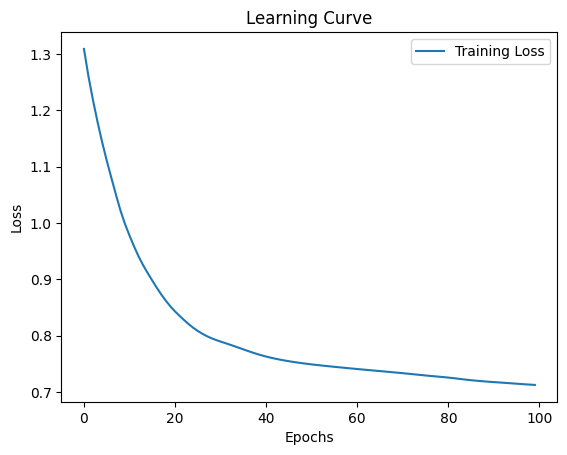

In [82]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [83]:
index_to_target = {0: 'A+', 1: 'T+', 2: 'N+'}

In [84]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()

    for i in range(y_train_np.shape[1]):
        print(f"Metrics for target {index_to_target.get(i)}:")
        print("Accuracy:", accuracy_score(y_train_np[:, i], y_pred_np[:, i]))
        print("Precision:", precision_score(y_train_np[:, i], y_pred_np[:, i]))
        print("Recall:", recall_score(y_train_np[:, i], y_pred_np[:, i]))
        precision = precision_score(y_train_np[:, i], y_pred_np[:, i])
        recall = recall_score(y_train_np[:, i], y_pred_np[:, i])
        print("F1 Score:", 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0)
        print('ROC AUC:', roc_auc_score(y_train_np[:, i], y_pred_np[:, i]))
        print()


Metrics for target A+:
Accuracy: 0.8732718894009217
Precision: 0.8947368421052632
Recall: 0.85
F1 Score: 0.8717948717948718
ROC AUC: 0.8735981308411216

Metrics for target T+:
Accuracy: 0.8847926267281107
Precision: 0.9230769230769231
Recall: 0.8372093023255814
F1 Score: 0.878048780487805
ROC AUC: 0.8843580758203249

Metrics for target N+:
Accuracy: 0.9055299539170507
Precision: 0.9014778325123153
Recall: 0.8970588235294118
F1 Score: 0.8992628992628993
ROC AUC: 0.9050511508951407



In [85]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # For multitask (MTL) evaluation, print metrics for each target
    for i in range(y_test_np.shape[1]):
        print(f"Test Metrics for target {index_to_target.get(i)}:")
        print("Test Accuracy:", accuracy_score(y_test_np[:, i], y_test_pred_np[:, i]))
        print("Test Precision:", precision_score(y_test_np[:, i], y_test_pred_np[:, i]))
        print("Test Recall:", recall_score(y_test_np[:, i], y_test_pred_np[:, i]))
        precision = precision_score(y_test_np[:, i], y_test_pred_np[:, i])
        recall = recall_score(y_test_np[:, i], y_test_pred_np[:, i])
        print("Test F1 Score:", 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0)
        print('Test ROC AUC:', roc_auc_score(y_test_np[:, i], y_test_pred_np[:, i]))
        print()

Test Metrics for target A+:
Test Accuracy: 0.8256880733944955
Test Precision: 0.8372093023255814
Test Recall: 0.75
Test F1 Score: 0.7912087912087912
Test ROC AUC: 0.8176229508196722

Test Metrics for target T+:
Test Accuracy: 0.908256880733945
Test Precision: 0.9090909090909091
Test Recall: 0.8695652173913043
Test F1 Score: 0.888888888888889
Test ROC AUC: 0.9030365769496204

Test Metrics for target N+:
Test Accuracy: 0.926605504587156
Test Precision: 0.975
Test Recall: 0.8478260869565217
Test F1 Score: 0.9069767441860466
Test ROC AUC: 0.915976535541753

